## Imports

In [1]:
# Data Manipulation and Analysis
import numpy as np
import pandas as pd

# Imbalanced Data Handling
from imblearn.over_sampling import SMOTE
from collections import Counter

# Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Utility Functions
from utils import encode_blood_pressure,categorize_glucose

In [2]:
cleaned_df = pd.read_csv("data/cleaned_df.csv")

## Feature Engineering

Below, numerous features are computed, among which is the Homeostatic Model Assessment of Insulin Resistance (HOMA-IR). These features collectively contribute to the model's predictive capability. HOMA-IR, in particular, assesses insulin resistance by considering fasting plasma glucose and insulin levels. Evaluating the importance of these features in model predictions provides insights into various aspects of metabolic health and risk assessment for conditions like diabetes.

In [3]:
cleaned_df['HOMA_IR'] = (cleaned_df['Glucose'] * cleaned_df['Insulin']) / 22.5
cleaned_df['BloodPressure_Category'] = cleaned_df['BloodPressure'].apply(encode_blood_pressure)
cleaned_df['BloodPressure_Category'] = cleaned_df["Glucose"].apply(categorize_glucose)
cleaned_df['Glucose_BMI_Interact'] = cleaned_df['Glucose'] * cleaned_df['BMI']
cleaned_df['Age_Insulin_Interact'] = cleaned_df['Age'] * cleaned_df['Insulin']
cleaned_df['Age_BMI_Interact'] = cleaned_df['Age'] * cleaned_df['BMI']
cleaned_df['Age_Pregnancies_Interact'] = cleaned_df['Age'] * cleaned_df['Pregnancies']
cleaned_df['Insulin_skin_Interact'] = cleaned_df['Insulin'] * cleaned_df['SkinThickness']
cleaned_df['Family_History'] = cleaned_df['DiabetesPedigreeFunction'].apply(lambda x: 1 if x > 1.8 else 0)
cleaned_df['SkinThickness_to_BMI_Ratio'] = cleaned_df['SkinThickness'] * cleaned_df['BMI']

bins = [0, 30, 50, 100]  # Define age group bins
labels = [0, 1, 2]  # Define labels for age groups
cleaned_df['Age_Group'] = pd.cut(cleaned_df['Age'], bins=bins, labels=labels, right=False)


cleaned_df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,HOMA_IR,BloodPressure_Category,Glucose_BMI_Interact,Age_Insulin_Interact,Age_BMI_Interact,Age_Pregnancies_Interact,Insulin_skin_Interact,Family_History,SkinThickness_to_BMI_Ratio,Age_Group
0,6.0,148.0,72.0,35.0,155.548223,33.6,0.627,50.0,1.0,1023.161647,2,4972.8,7777.411168,1680.0,300.0,5444.187817,0,1176.0,2
1,1.0,85.0,66.0,29.0,155.548223,26.6,0.351,31.0,0.0,587.626622,0,2261.0,4821.994924,824.6,31.0,4510.898477,0,771.4,1
2,8.0,183.0,64.0,0.0,155.548223,23.3,0.672,32.0,1.0,1265.125550,2,4263.9,4977.543147,745.6,256.0,0.000000,0,0.0,1
3,1.0,89.0,66.0,23.0,94.000000,28.1,0.167,21.0,0.0,371.822222,0,2500.9,1974.000000,590.1,21.0,2162.000000,0,646.3,0
4,0.0,137.0,40.0,35.0,168.000000,43.1,2.288,33.0,1.0,1022.933333,2,5904.7,5544.000000,1422.3,0.0,5880.000000,1,1508.5,1


## Synthetic Minority Oversampling Technique

SMOTE is an oversampling technique where the synthetic samples are generated for the minority class. This algorithm helps to overcome the overfitting problem posed by random oversampling.

In [4]:
X = cleaned_df[cleaned_df.columns.drop("Outcome")].values
y = cleaned_df["Outcome"].values

print("Original dataset shape:", Counter(y))

# Record the range of each feature in the original dataset
feature_ranges = [(X[:, i].min(), X[:, i].max()) for i in range(X.shape[1])]

# Apply SMOTE to generate synthetic samples
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("Resampled dataset shape:", Counter(y_resampled))

# Check if synthetic samples are within the range of the original data
for i in range(X_resampled.shape[1]):
    min_val, max_val = feature_ranges[i]
    X_resampled[:, i] = np.clip(X_resampled[:, i], min_val, max_val)




Original dataset shape: Counter({0.0: 500, 1.0: 268})
Resampled dataset shape: Counter({1.0: 500, 0.0: 500})


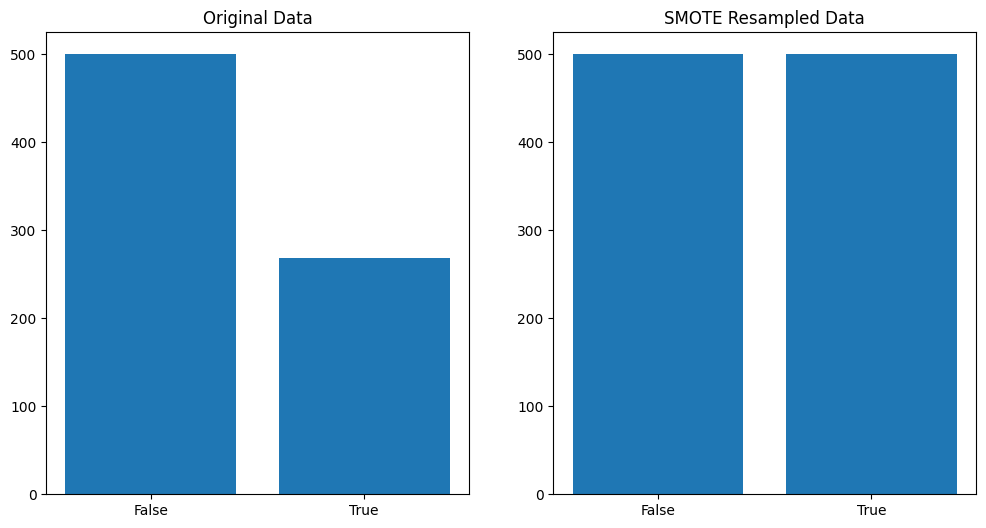

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.bar(Counter(y).keys(), Counter(y).values())
ax1.set_title('Original Data')
ax1.set_xticks([0, 1])
ax1.set_xticklabels(['False', 'True'])

ax2.bar(Counter(y_resampled).keys(), Counter(y_resampled).values())
ax2.set_title('SMOTE Resampled Data')
ax2.set_xticks([0, 1])
ax2.set_xticklabels(['False', 'True'])

plt.show()

In [6]:
cleaned_df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome', 'HOMA_IR',
       'BloodPressure_Category', 'Glucose_BMI_Interact',
       'Age_Insulin_Interact', 'Age_BMI_Interact', 'Age_Pregnancies_Interact',
       'Insulin_skin_Interact', 'Family_History', 'SkinThickness_to_BMI_Ratio',
       'Age_Group'],
      dtype='object')

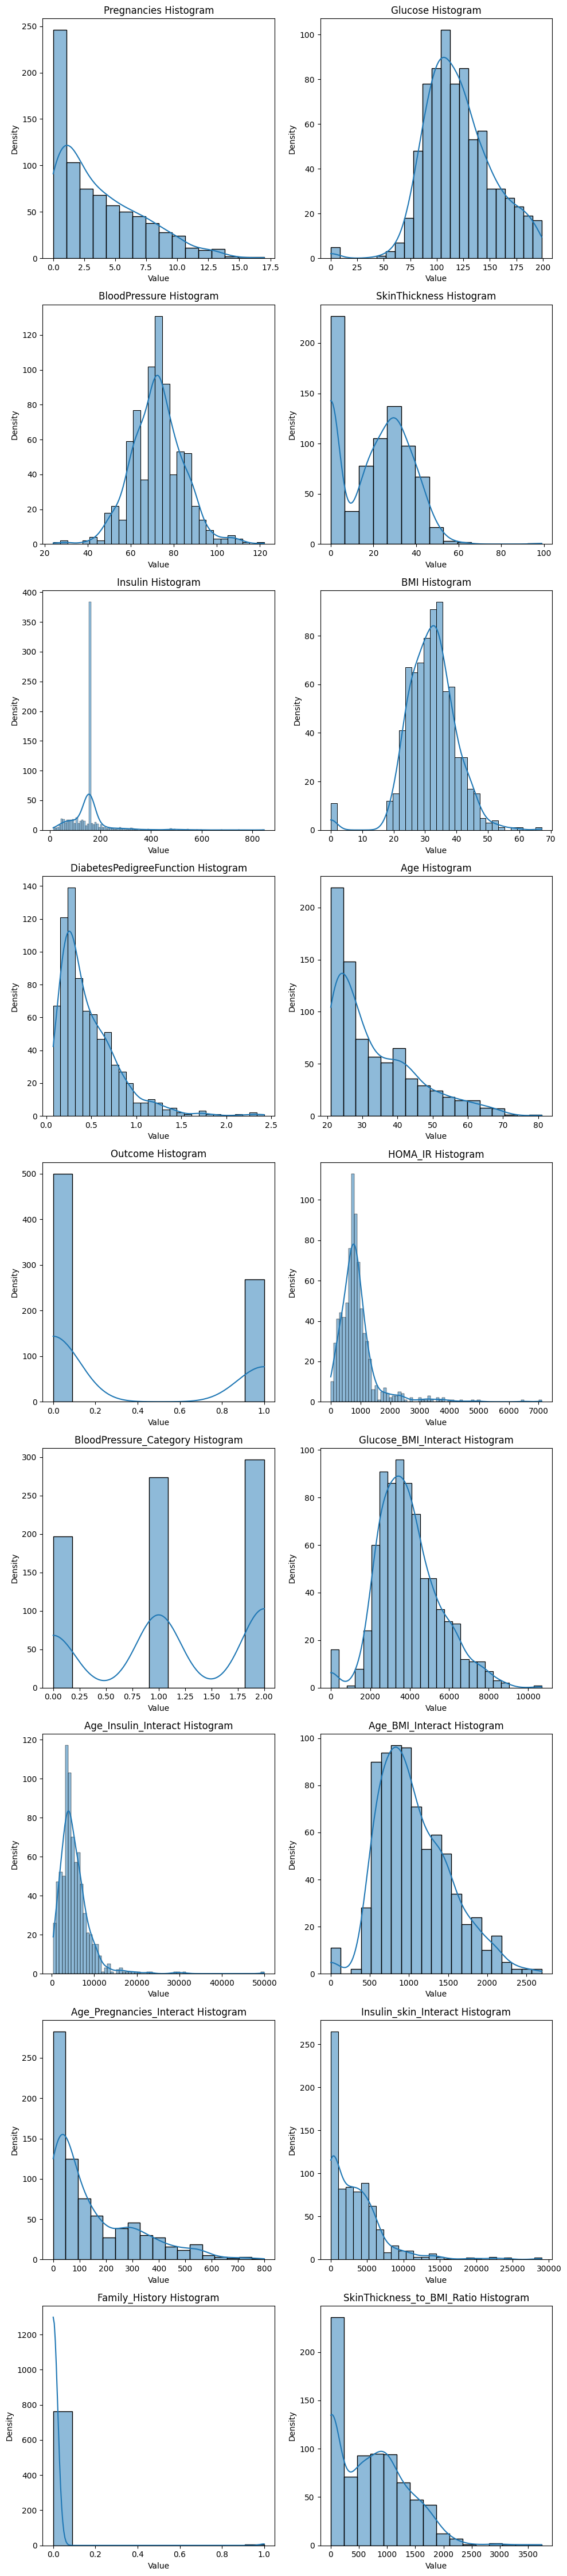

In [7]:
# Determine the layout of subplots based on the number of columns
num_cols = len(cleaned_df.columns)-2
num_rows = (num_cols + 1) // 2

# Create subplots using seaborn
fig, axes = plt.subplots(num_rows, 2, figsize=(10, 5 * num_rows))

# Plot histograms for all columns
for i, column in enumerate(cleaned_df.columns[:18]):
    row = i // 2
    col = i % 2
    sns.histplot(cleaned_df[column], ax=axes[row, col], kde=True)
    axes[row, col].set_title(column + " Histogram")
    axes[row, col].set_xlabel("Value")
    axes[row, col].set_ylabel("Density")

# Adjust layout
plt.tight_layout()
plt.show()

In [9]:
data = np.column_stack((X_resampled, y_resampled))
np.savetxt("data/data_np.csv", data, delimiter=",")